In [4]:
from qiskit import transpile, schedule, assemble
import pickle
from qiskit import pulse, execute, QuantumCircuit
from qiskit.pulse.library import GaussianSquare
from qiskit.pulse import Schedule, Play, Acquire
import numpy as np
import typing
import matplotlib.pyplot as plt
from qiskit.pulse.channels import DriveChannel, ControlChannel, AcquireChannel, MeasureChannel, MemorySlot
from qiskit import IBMQ
from qiskit.pulse.instructions.play import Play
from qiskit.transpiler.passes.scheduling.calibration_creators import RZXCalibrationBuilder

In [5]:
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter, TomographyFitter
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info.operators.channel import Choi, Kraus, PTM
from qiskit.circuit import QuantumCircuit, QuantumRegister, Gate
from qiskit import transpile, schedule, assemble
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel
from qiskit.visualization import(
  plot_state_city,
  plot_bloch_multivector,
  plot_state_paulivec,
  plot_state_hinton,
  plot_state_qsphere)

In [6]:
from qiskit.providers.aer.noise.errors.errorutils import standard_gate_unitary
from qiskit.quantum_info.operators.measures import process_fidelity
from qiskit.quantum_info import Choi, Kraus, Operator
import qiskit.quantum_info as qi

In [7]:
#IBMQ.enable_account('bc105c39d9a7126c0d0676289f99065f525c6d739c807848153f6d1dd19907d6d433577b8c34a1959654f82f12418f09d115a1b8eb3db8dab6fabe1192da1643')

In [5]:
#IBMQ.save_account('bc105c39d9a7126c0d0676289f99065f525c6d739c807848153f6d1dd19907d6d433577b8c34a1959654f82f12418f09d115a1b8eb3db8dab6fabe1192da1643',overwrite=True)

In [8]:
provider = IBMQ.load_account()

In [ ]:
reservation_provider = IBMQ.get_provider(
    hub='ibm-q-startup', 
    group='phasecraft-ltd',
    project='reservations'
)

hardware_backends = {
    "ibmq_casablanca" : reservation_provider.backends.ibmq_casablanca,
    "ibmq_bogota" : reservation_provider.backends.ibmq_bogota
}

In [9]:
provider_pulse =IBMQ.get_provider(hub='ibm-q-startup', group='phasecraft-ltd', project='pulse-level-cont')

In [10]:
backend = provider_pulse.get_backend('ibmq_bogota')#,mode='dedicated')
config = backend.configuration()
props = backend.properties()
defaults = backend.defaults()
calibrations = defaults.instruction_schedule_map

# Depth 4

In [11]:
basis_gates = config.basis_gates
inst_map = defaults.instruction_schedule_map
RZX_cals = RZXCalibrationBuilder(backend)

In [12]:
print(inst_map)

<InstructionScheduleMap(1Q instructions:
  q0: {'u3', 'sx', 'id', 'rz', 'u1', 'u2', 'x', 'measure'}
  q1: {'u3', 'sx', 'id', 'rz', 'u1', 'u2', 'x', 'measure'}
  q2: {'u3', 'sx', 'id', 'rz', 'u1', 'u2', 'x', 'measure'}
  q3: {'u3', 'sx', 'id', 'rz', 'u1', 'u2', 'x', 'measure'}
  q4: {'u3', 'sx', 'id', 'rz', 'u1', 'u2', 'x', 'measure'}
Multi qubit instructions:
  (0, 1): {'cx'}
  (1, 0): {'cx'}
  (1, 2): {'cx'}
  (2, 1): {'cx'}
  (2, 3): {'cx'}
  (3, 2): {'cx'}
  (3, 4): {'cx'}
  (4, 3): {'cx'}
  (0, 1, 2, 3, 4): {'measure'}
)>


In [13]:
def depth4(angle: float, qubits: list, backend):
    
    """
        returns a circuit
        ZX(1, 2)(t1)
        ZX(0, 1)(t2)
        ZX(1, 2)(t2)
        ZX(0, 1)(t1)
        which, overall, results in a gate
        ...
    """
    config = backend.configuration()
    props = backend.properties()
    defaults = backend.defaults()
    
    calibrations = defaults.instruction_schedule_map
    basis_gates = config.basis_gates
    inst_map = defaults.instruction_schedule_map
    RZX_cals = RZXCalibrationBuilder(backend)
    
    qregs = QuantumRegister(config.n_qubits)
    q0 = qregs[qubits[0]].index
    q1 = qregs[qubits[1]].index
    q2 = qregs[qubits[2]].index
    
    z=0
    t1 = (1 / 2) * np.arctan2(
        ((-1)**z)*np.sqrt(np.sin(2 * angle)) / (np.cos(angle) + np.sin(angle)),
        1 / (np.cos(angle) + np.sin(angle))
        )
    
    t2 = (1 / 2) * np.arctan2(
        - ((-1)**z)*np.sqrt(np.sin(2 * angle)),
        np.cos(angle) - np.sin(angle)
        )
        
    scheds = [{'name':'RZX_t1_q0_q1','sched': RZX_cals.get_calibration([2*t1],[q0, q1]), 'qubits': [q0, q1]},  
              {'name': 'RZX_t2_q1_q2', 'sched': RZX_cals.get_calibration([2*t2],[q1, q2]), 'qubits': [q1, q2]}, 
              {'name':'RZX_t2_q0_q1','sched': RZX_cals.get_calibration([2*t2],[q0, q1]), 'qubits': [q0, q1]}, 
              {'name': 'RZX_t1_q1_q2', 'sched': RZX_cals.get_calibration([2*t1],[q1, q2]), 'qubits': [q1, q2]}]
    
   
    circuit = QuantumCircuit(qregs)

    for sch in scheds:
        
        gate_name = sch['name']
        sched = sch['sched']
        qs = sch['qubits']
              
        basis_gates += [gate_name]
        inst_map.add(gate_name, [qs[0], qs[1]], sched)
        circuit.append(Gate(gate_name, 2, []), qargs=[qs[0], qs[1]]) 
        
    return {'circuit': circuit, 'inst_map': inst_map, 'basis_gates':basis_gates}
    

    
   

# Quick Check

In [20]:
test_angle = 0.4
test_qubits = [0, 1, 2]
ideal_circ = QuantumCircuit(3)
z=0


t1 = (1 / 2) * np.arctan2(
        ((-1)**z)*np.sqrt(np.sin(2 * test_angle)) / (np.cos(test_angle) + np.sin(test_angle)),
        1 / (np.cos(test_angle) + np.sin(test_angle))
        )
    
t2 = (1 / 2) * np.arctan2(
        - ((-1)**z)*np.sqrt(np.sin(2 * test_angle)),
        np.cos(test_angle) - np.sin(test_angle)
        )

ideal_circ.rzx(2*t1, 0, 1)
ideal_circ.rzx(2*t2, 1, 2)
ideal_circ.rzx(2*t2, 0, 1)
ideal_circ.rzx(2*t1, 1, 2)

exp = depth4(test_angle, test_qubits, backend)
(mod_basis_gates, mod_inst_map , test_circuit) = (exp['basis_gates'],exp['inst_map'],exp['circuit'])

<ipython-input-13-d3f5895b4358>:22: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q0 = qregs[qubits[0]].index
<ipython-input-13-d3f5895b4358>:23: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q1 = qregs[qubits[1]].index
<ipython-input-13-d3f5895b4358>:24: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q2 = qregs[qubits[2]].index


In [21]:
ideal = qi.Operator(ideal_circ)

In [22]:
ideal_circ.draw()

┌───────────────┐                 ┌───────────────┐                 
q_0: ┤0              ├─────────────────┤0              ├─────────────────
     │  RZX(0.70273) │┌───────────────┐│  RZX(-1.0103) │┌───────────────┐
q_1: ┤1              ├┤0              ├┤1              ├┤0              ├
     └───────────────┘│  RZX(-1.0103) │└───────────────┘│  RZX(0.70273) │
q_2: ─────────────────┤1              ├─────────────────┤1              ├
                      └───────────────┘                 └───────────────┘

In [23]:
test_circuit.draw()

┌───────────────┐                 ┌───────────────┐                 
q4_0: ┤0              ├─────────────────┤0              ├─────────────────
      │  RZX_t1_q0_q1 │┌───────────────┐│  RZX_t2_q0_q1 │┌───────────────┐
q4_1: ┤1              ├┤0              ├┤1              ├┤0              ├
      └───────────────┘│  RZX_t2_q1_q2 │└───────────────┘│  RZX_t1_q1_q2 │
q4_2: ─────────────────┤1              ├─────────────────┤1              ├
                       └───────────────┘                 └───────────────┘
q4_3: ────────────────────────────────────────────────────────────────────
                                                                          
q4_4: ────────────────────────────────────────────────────────────────────

In [24]:
print(f' 2*t1 = {2*t1} \n 2*t2 = {2*t2}')

 2*t1 = 0.7027316423911621 
 2*t2 = -1.0102574915577722


In [25]:
#test_circuit = transpile(test_circuit, backend, basis_gates, initial_layout = [1 , 3,  5])
qpt_circuits = process_tomography_circuits(test_circuit, test_qubits) 
qpt_circuits = transpile(qpt_circuits, backend, basis_gates=mod_basis_gates)
qpt_schedules = schedule(qpt_circuits, backend, inst_map=mod_inst_map)

/home/laura/.local/lib/python3.9/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:465: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += preparation(prep_label[j], prep_qubits[j])
/home/laura/.local/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
/home/laura/.local/lib/python3.9/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = prep 

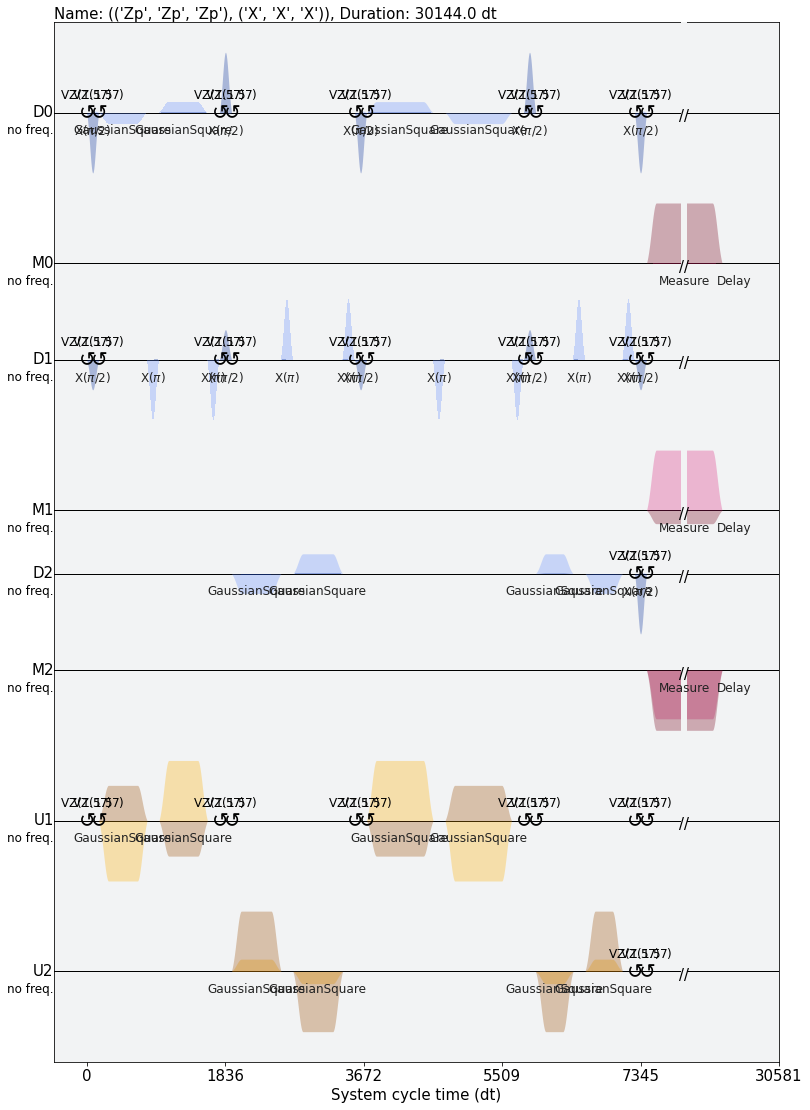

In [26]:
qpt_schedules[0].draw()

In [ ]:
#job1 = execute(qpt_schedules[0:900], backend=backend, shots=300)

In [ ]:
#job2 = execute(qpt_schedules[900:], backend=backend, shots=300)

In [ ]:
job2.status()

In [ ]:
res1 = job1.result() #backend.retrieve_job('609516643e5b9421895b22f8').result()
res2 = job2.result() #backend.retrieve_job('60951563d422bae1e1dda962').result()

In [ ]:
res1.results += res2.results

In [ ]:
#res1

In [ ]:
process_data = ProcessTomographyFitter(res1, qpt_circuits, meas_basis='Pauli', prep_basis='Pauli')

In [ ]:
choi_fit = process_data.fit(method='lstsq')#standard_weights=True,kwargs={ "trace_preserving":True, "PSD": True})
choi_fit = choi_fit.data
   

In [ ]:
fid = qi.average_gate_fidelity(channel=Choi(choi_fit),target=Operator(ideal.data))
    

In [ ]:
print(fid)

In [ ]:
len(choi_fit)

In [ ]:
choi_ideal = Choi(Operator(ideal.data))